# Import libraries

In [1]:
import peridynamics as pd
import numpy as np
import matplotlib.pyplot as plt

# Material Constants

In [2]:
# Material used = soda-lime glass
E = 72e9 # Young's modulus [Pa]
nu = 0.2 # Poisson's ratio
rho = 2440 # Density [kg/m³]
G0 = 3.8 # Energy release rate [J/m²]

# Peridynamic Parameters

In [3]:
horizon = 0.05 # Peridynamic horizon (δ) [m]
m=4 # Mesh ration: number of spacings inside the horizon (m = horizon/h) - If in doubt, a value between 4 and 6 is usually engough for 2D simulations
omega=3 # Influence function option: normalized function type (1 --> Exp, 2 --> Constant, 3 --> Conical, 4 --> Cubic polynomial, 5 --> P5, 6 --> P7, 7 --> Singular)
gamma=1 # Influence function option (integer)
par_omega = [horizon,omega,gamma]

# Generate Mesh

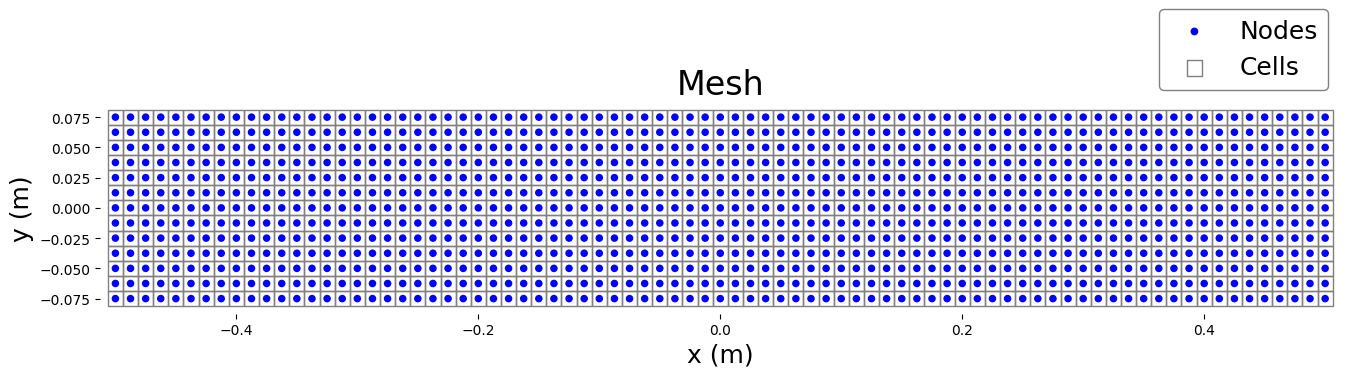

In [4]:
h=horizon/m # Grid spacing [m] h=0.05/4 --> h=0.0125 m
size_x=1 # [m]
size_y=0.15 # [m]
mesh=pd.Mesh() # Instantiate mesh object
# Generate the rectangular mesh with generate_rectangular_mesh() or a non rectangular mesh with generate_mesh_constrained_within_points()
mesh.generate_rectangular_mesh(h,size_x,size_y)
# Optionally, use aditional methods such as center(), offset(), rotate(), plot(), etc.
mesh.center()
mesh.plot()

# Generate Family

In [5]:
PA_alg='PA-AC' # Partial area algorithm: "FA", "FA+", "PA-PDLAMMPS", "PA-PDLAMMPS+", "PA-HHB", "PA-HBB+", "PA-AC", "IPA-AC"
SC_alg='None' # Surface correction algorithm: "None", "Volume"
family=pd.Family(mesh,horizon,m,PA_alg,SC_alg,silent=True) # silent = True can speed up the process

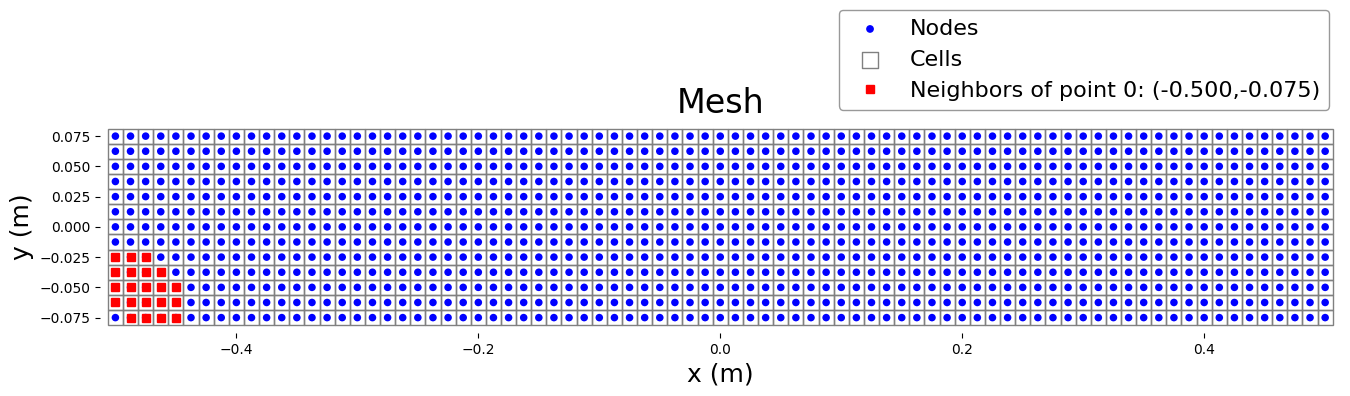

In [6]:
# Visualization of neighbors of point "0": (-0.500,-0.075)
fig,ax=mesh.get_fig_ax()
ax.plot(family.xj[0][:,0],family.xj[0][:,1],'rs',label=f'Neighbors of point 0: ({mesh.x[0]:.3f},{mesh.y[0]:.3f})')
ax.legend(loc='lower right',bbox_to_anchor=(1, 1, 0, 0),fontsize=16,edgecolor='grey')
fig

# Set Boundary Conditions

In [7]:
# Users can prescribe body forces, displacements and velocities constraints, depending on the application and solver used
# Also it's necessary to prescribe additional options: "damage_dependent_SC" and "damage_on"
# Optionally, a crack can also be prescribed by "set_crackIn"
bc=pd.BoundaryConditions()
# Choose which nodes from the mesh will be under stress
stress_nodes=np.hstack((
    mesh.get_borders_ind('top')[int(np.ceil(3/10*len(mesh.get_borders_ind('top'))))-2:int(np.ceil(3/10*len(mesh.get_borders_ind('top'))))+1],
    mesh.get_borders_ind('top')[int(np.ceil(7/10*len(mesh.get_borders_ind('top'))))-2:int(np.ceil(7/10*len(mesh.get_borders_ind('top'))))+1]
    ))
stresses=[0,-6e6/mesh.h,0] # σx, σy and τxy [Pa=N/m²]
bc.set_body_forces(mesh,stresses,stress_nodes)

# Similar for the prescribed displacements. Here we have more granularity
disp_nodes=np.hstack((mesh.get_borders_ind('bottom')[1:5],mesh.get_borders_ind('bottom')[-5:-1]))
disp_bools_x=np.hstack((np.full(int(len(disp_nodes)/2),True),np.full(int(len(disp_nodes)/2),False)))
disp_bools_y=np.full_like(disp_nodes,True)
disp_values_x=np.zeros_like(disp_nodes)
disp_values_y=np.zeros_like(disp_nodes)
bc.set_displacement_constraints(mesh,
    disp_nodes,disp_bools_x,disp_bools_y,disp_values_x,disp_values_y,
)

# Damage boundary conditions
bc.set_damage_dependent_SC(False)
bc.set_damage_on(False) # True if applying damage to the model, false if not
bc.set_crackIn([[-0.3,-0.077],[-0.3,-0.075+0.05]]) # Coordinates of the crack initial segment

# bc.compute_dofj(family)
# bc.compute_noFail_ij(family)
# bc.initialize_brokenBonds(family) # (N,) --> with each being (j,crackSegments-1)

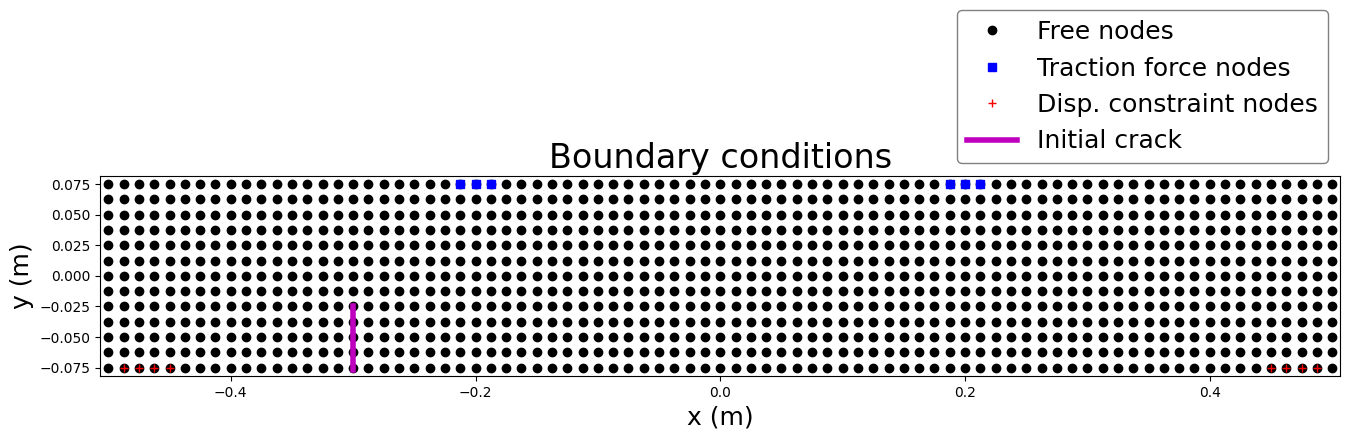

In [8]:
bc.plot()

# Choose Model

In [9]:
name='PMB' # LBB, LPS 2D, LSJ-T, Lipton Free Damage, PMB, PMB DTT
model=pd.Model(name,par_omega,E,G0,bc)
# model._initialize_history(family) # Not needed

# Configure solver and get results

In [10]:
# ---------- Configure solver and get results ----------
# solver = "Quasi-Static" # "Quasi-Static", "Dynamic/Explicit"
n_tot = 4 # Number of load steps
u_n,r,energy,phi=pd.solver_QuasiStatic(mesh,n_tot,bc,family,model,par_omega,penalty=1e10)

Check for broken bonds done.
Calculating the stiffness matrix... |----------------------------------------| 100.00 % | ETA = 0.00e+00 s Done.
Incremental solution found
Iter: 1 | Residual equal to: 34.13900225700422 | np.maximum residual to be: 1.8750000000000004
Calculating the stiffness matrix... |----------------------------------------| 100.00 % | ETA = 0.00e+00 s Done.
Incremental solution found
Iter: 2 | Residual equal to: 1.2658920374032095e-06 | np.maximum residual to be: 1.8750000000000004
Solution found for the step 1 out of 4
Calculating the stiffness matrix... |----------------------------------------| 100.00 % | ETA = 0.00e+00 s Done.
Incremental solution found
Iter: 1 | Residual equal to: 34.16348358827041 | np.maximum residual to be: 3.750000000000001
Calculating the stiffness matrix... |----------------------------------------| 100.00 % | ETA = 0.00e+00 s Done.
Incremental solution found
Iter: 2 | Residual equal to: 1.2397716914697718e-06 | np.maximum residual to be: 3.

# Visualize results

In [11]:
# If you need to interact with the graphic for rotation, it is necessary to change the matplotlib backend to "ipympl" (instalation might be necessary)
# plt.switch_backend('module://matplotlib_inline.backend_inline') # default
# plt.switch_backend('module://ipympl.backend_nbagg') # interactive backend for notebooks

## Displacement

Displacement vector converted.


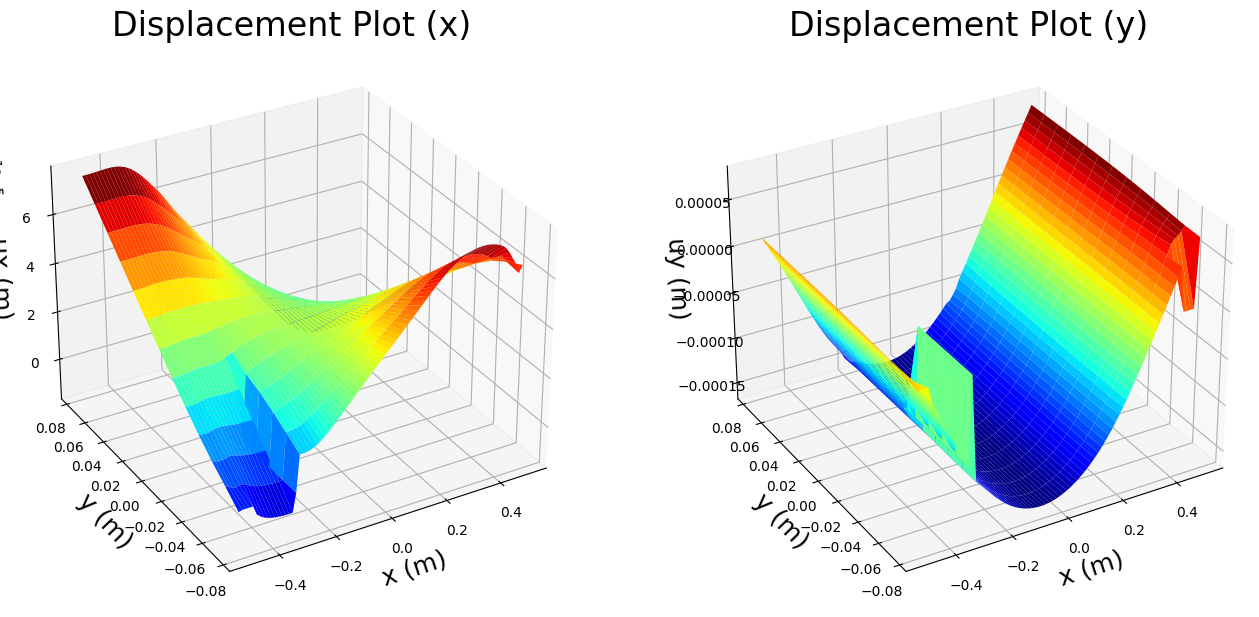

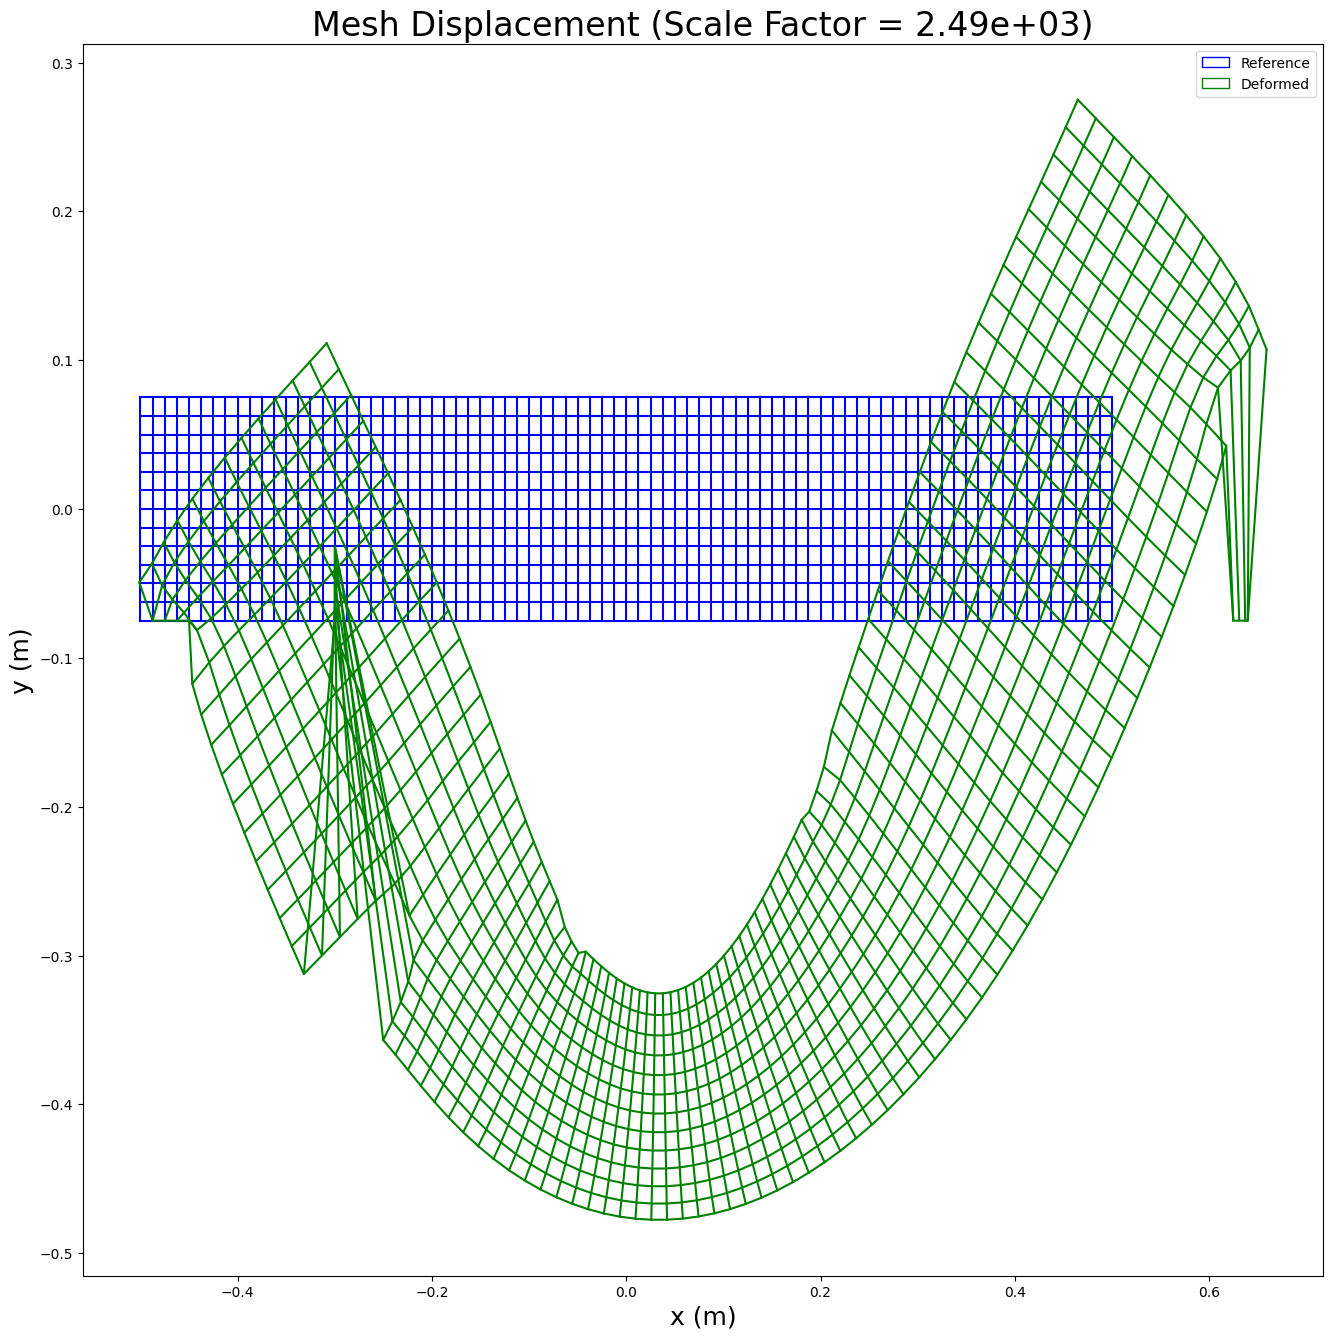

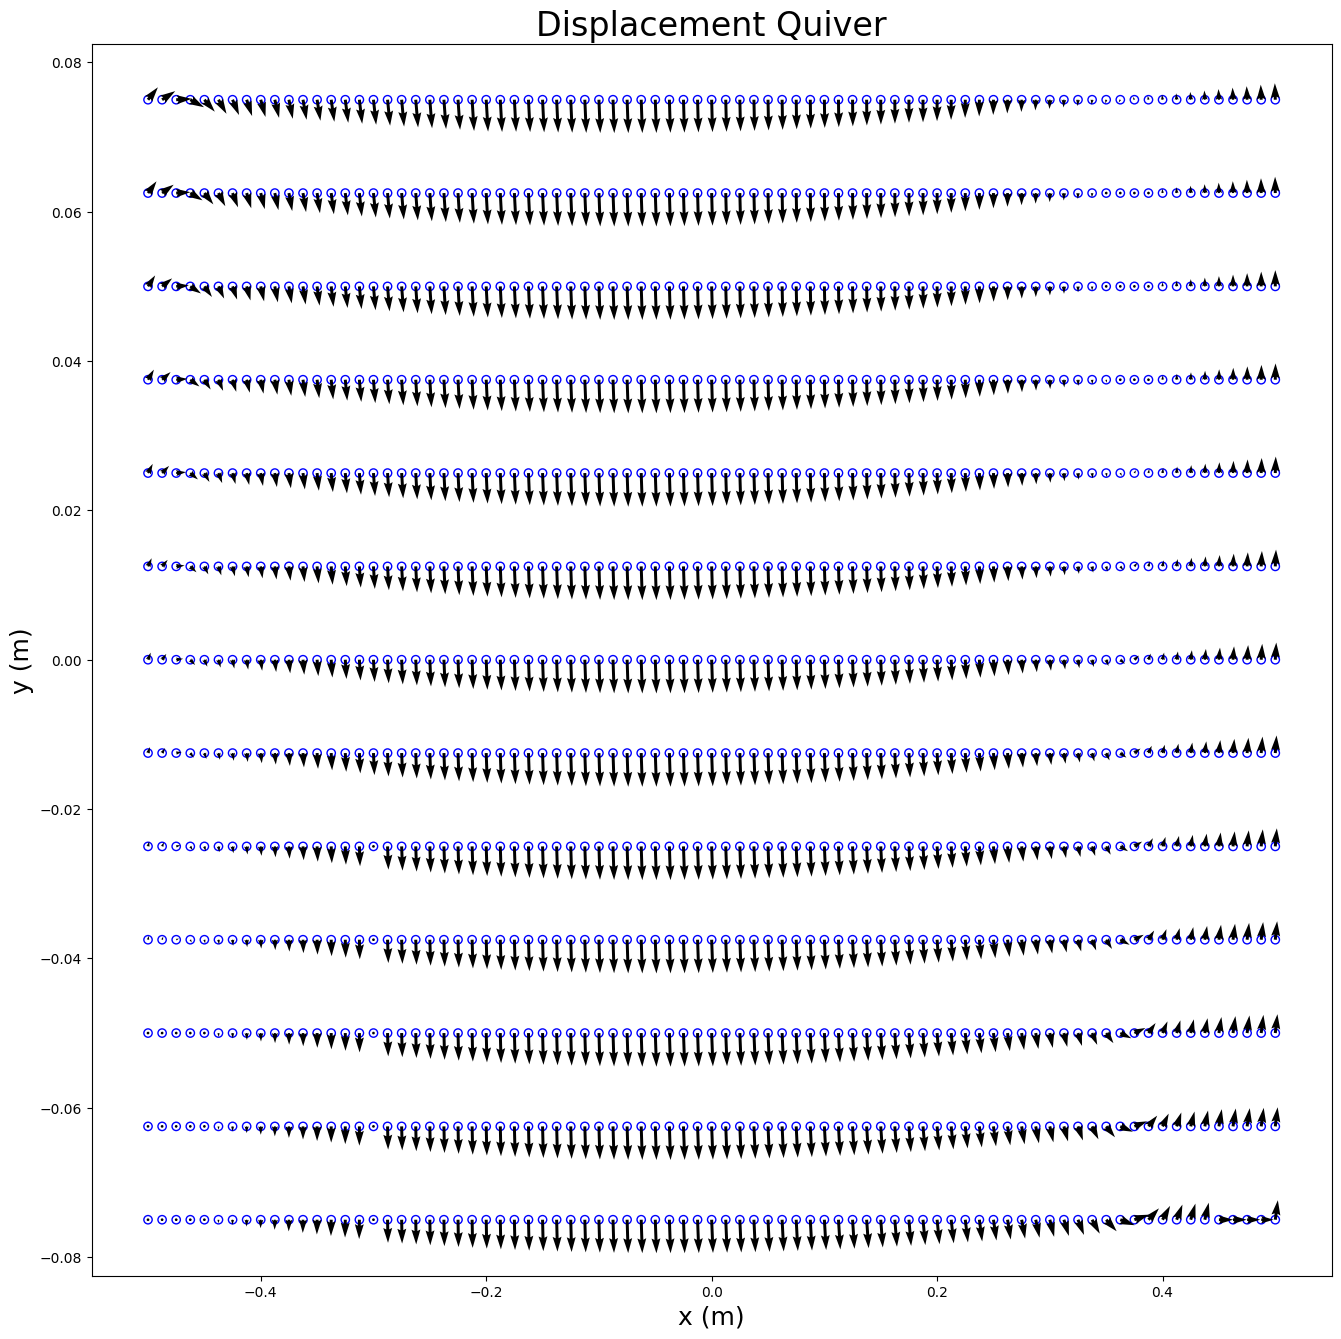

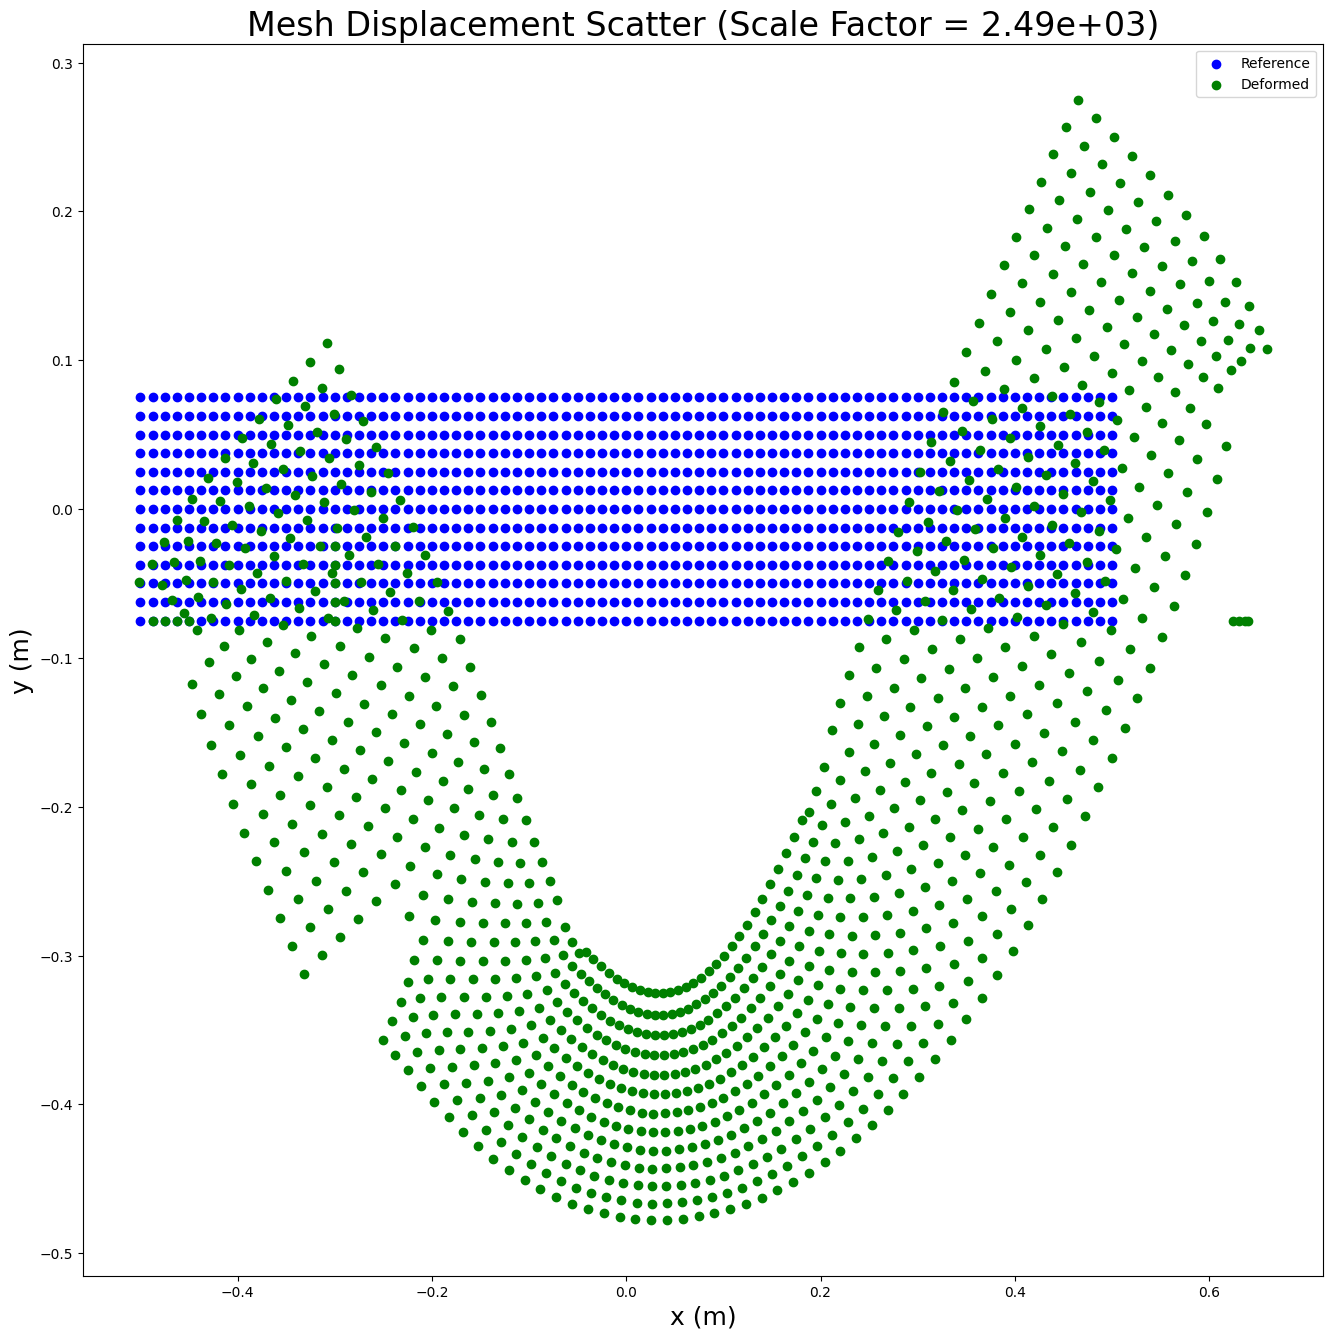

In [12]:
pd.plot_displacement(mesh,u_n,bc,aspect='auto')

## Strain

Displacement vector converted.


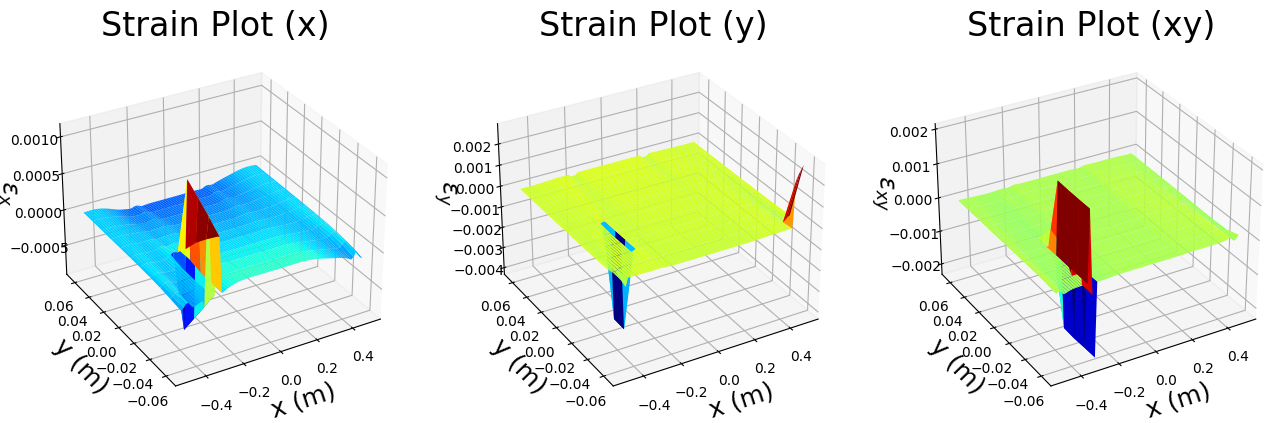

In [13]:
pd.plot_strain(mesh,u_n,bc,aspect='auto')

## Energy

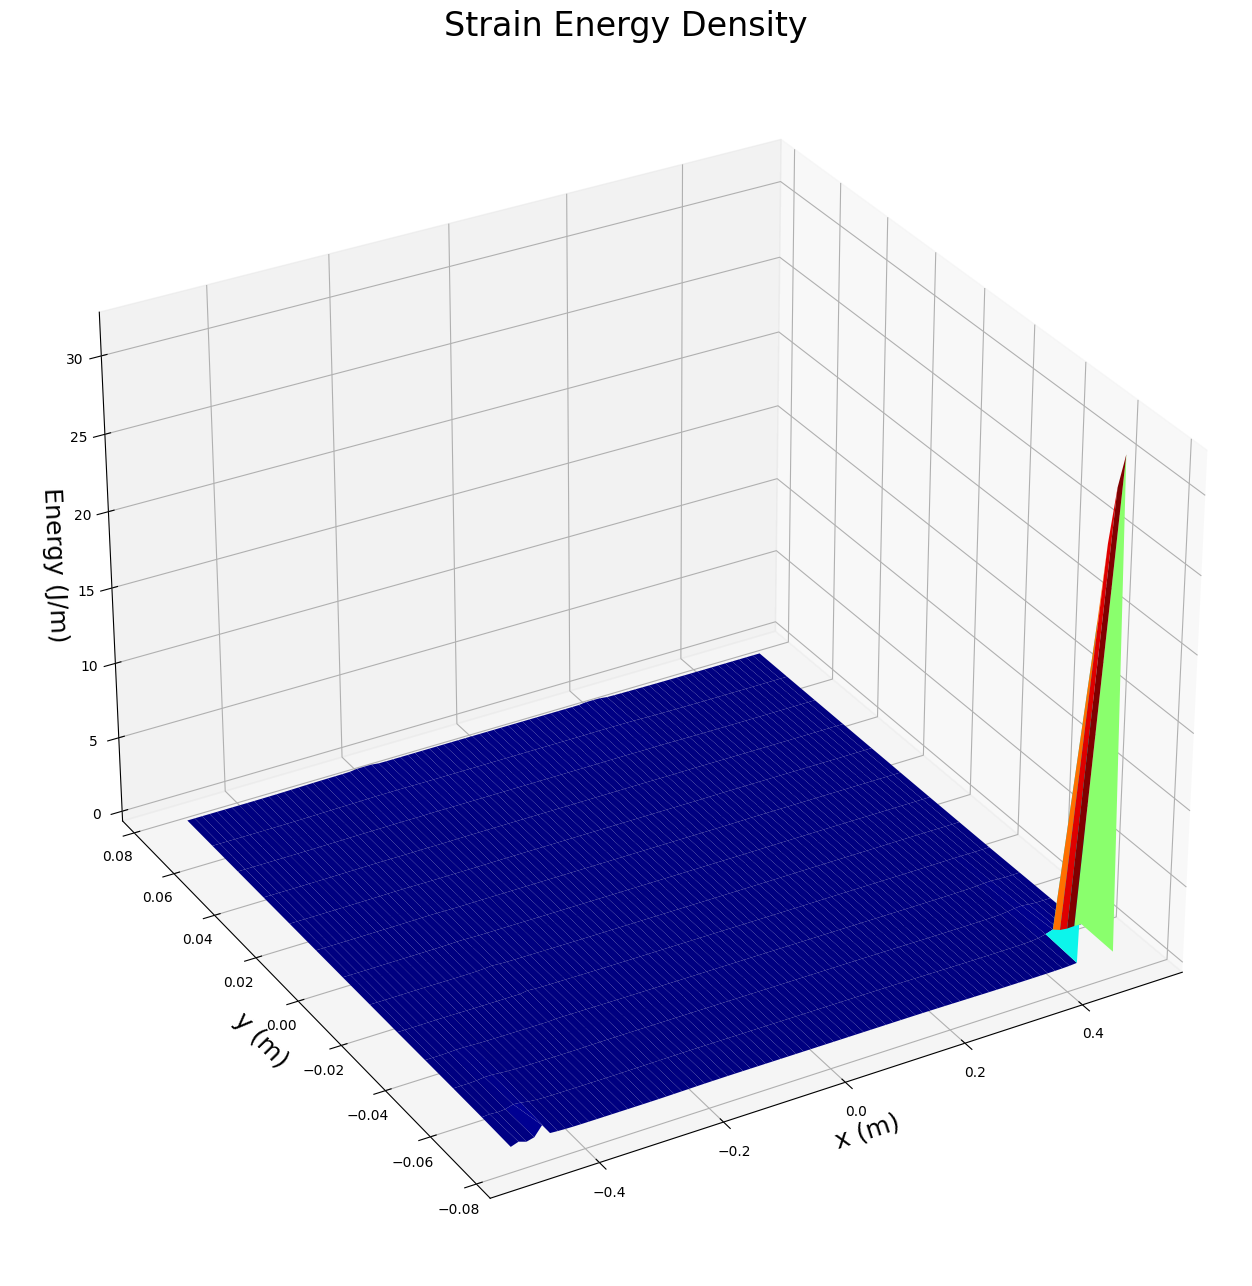

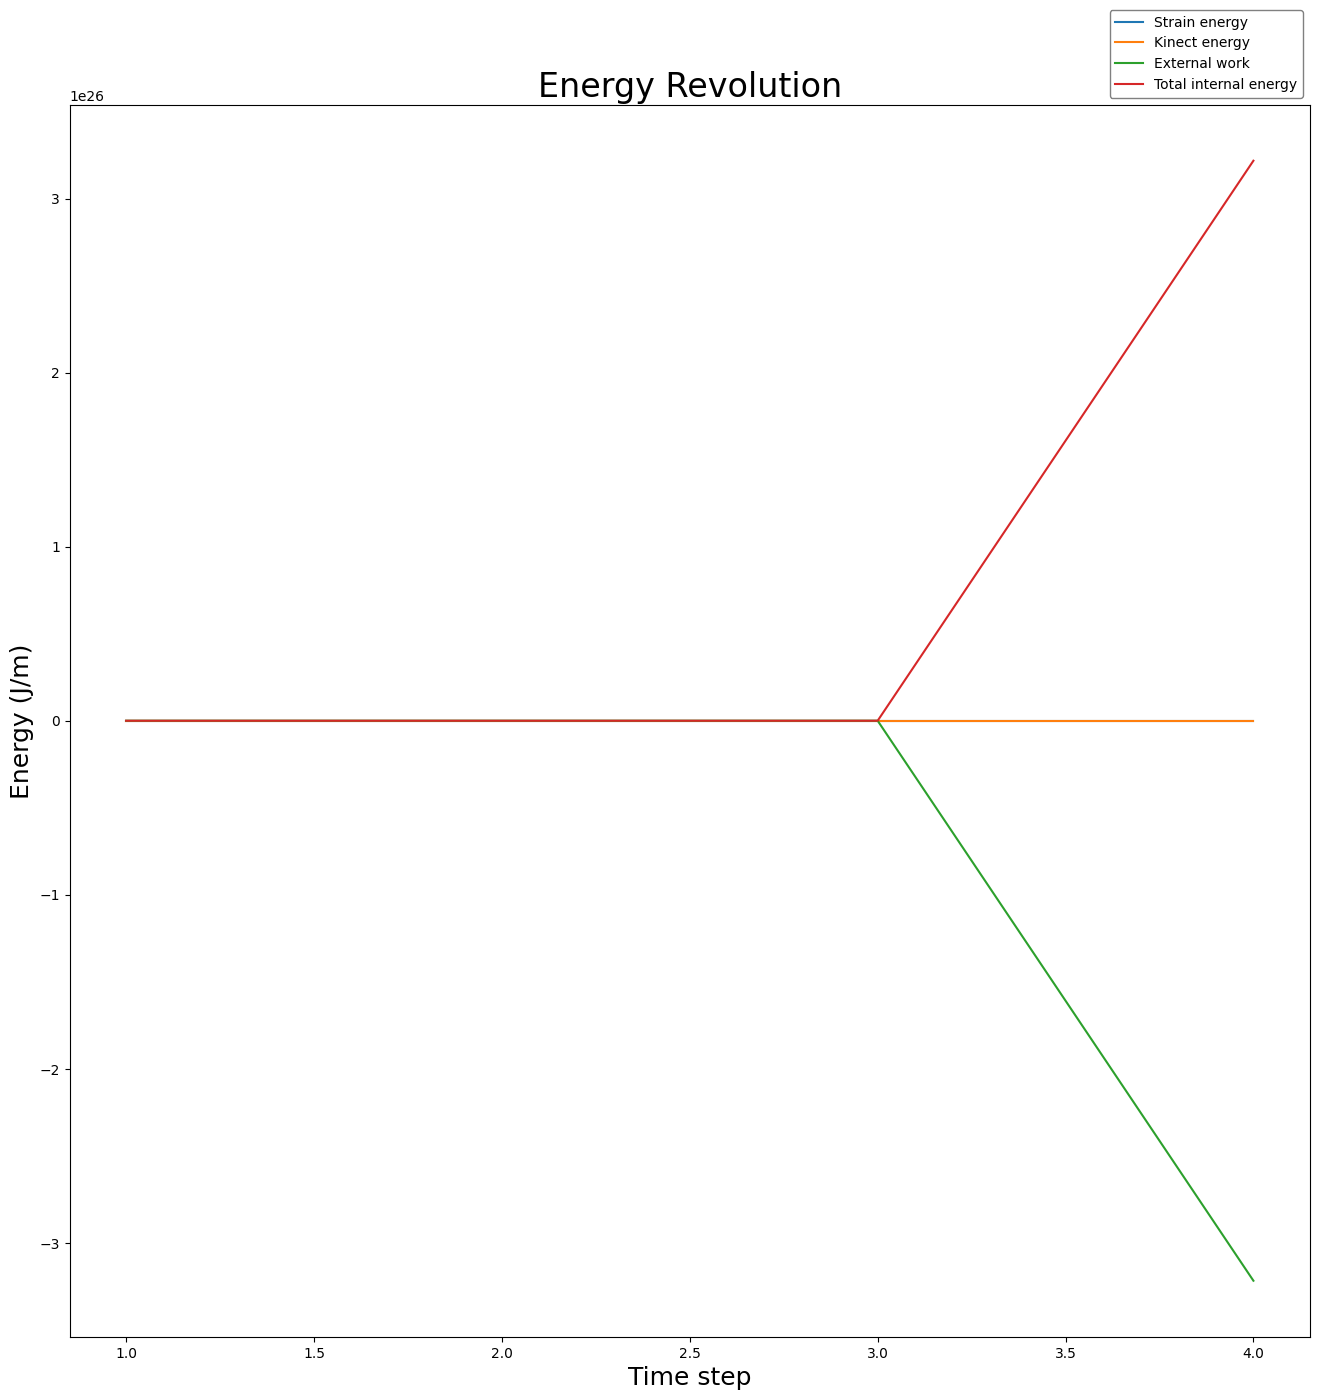

In [14]:
pd.plot_energy(mesh,energy,aspect='auto')

## Damage

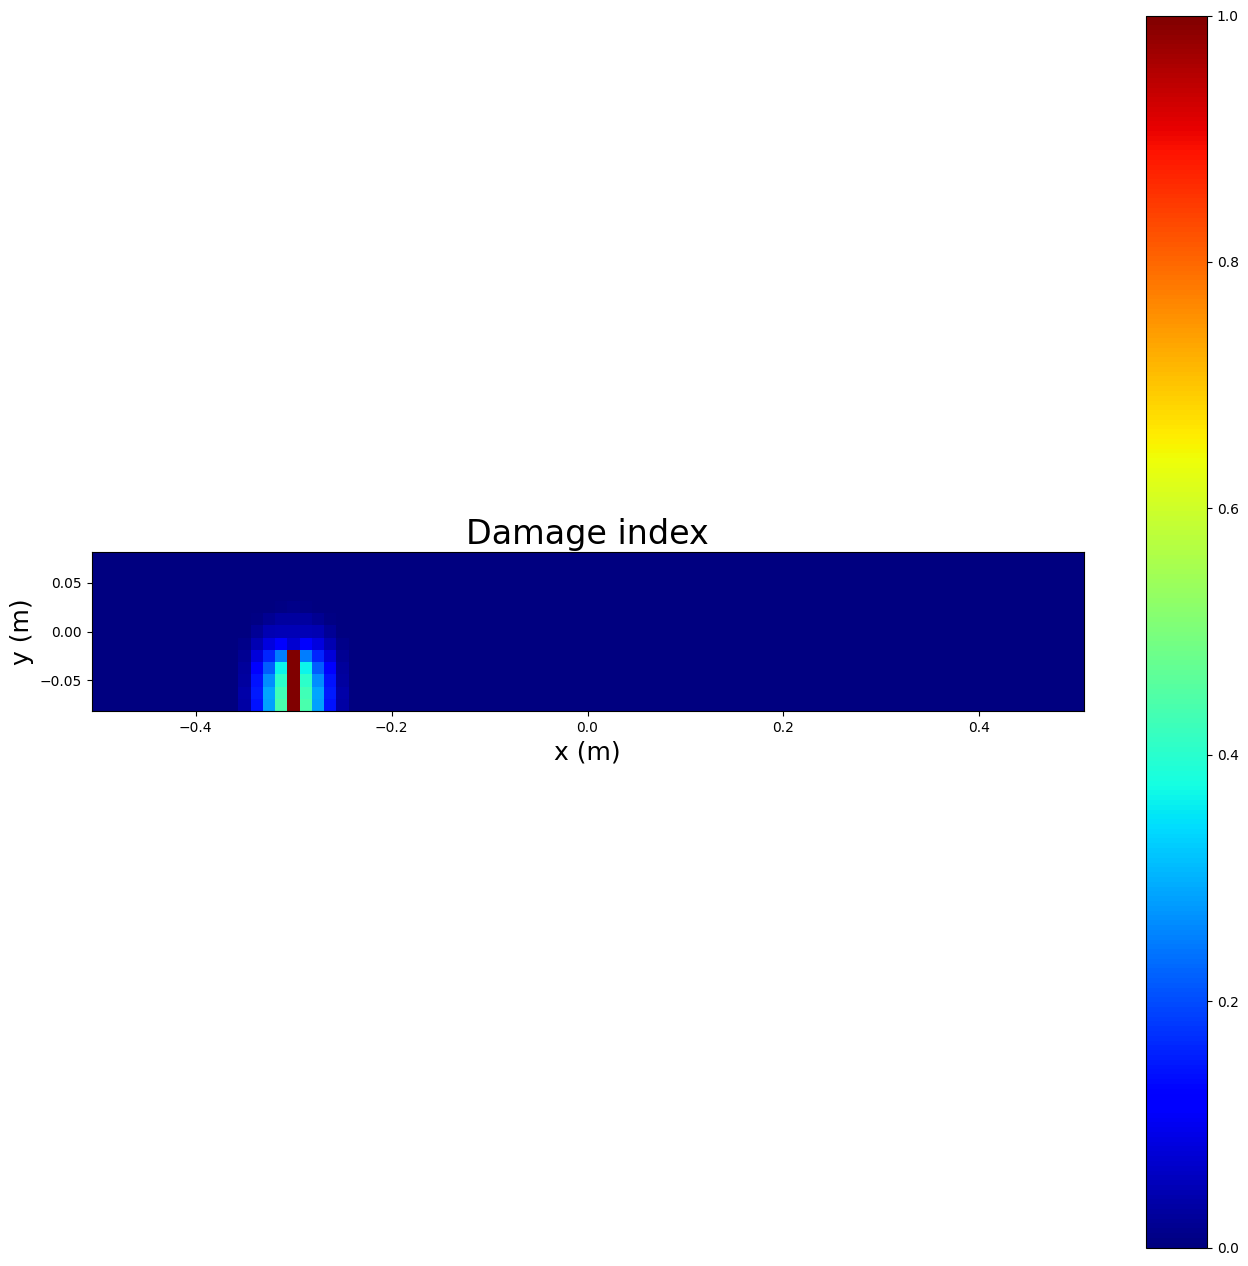

In [15]:
pd.plot_damage(mesh,phi)

# Save results

In [16]:
# Variable saving example
# In python, pickle has seen some security flaws, but using it for yourself can be safe and save a lot of time
pd.save_object(u_n,'un.pickle',r'C:\my folder')

Successfully saved file at C:\my folder\un.pickle


In [17]:
# Saving plot images as files
mesh_fig=mesh.get_fig_ax()[0]
bc_fig=bc.get_fig_ax()[0]
disp_figs=pd.plot_displacement(mesh,u_n,bc,return_fig_ax=True,silent=True,aspect='equalxy')[0]
strain_fig=pd.plot_strain(mesh,u_n,bc,return_fig_ax=True,silent=True,aspect='auto')[0]
energy_figs=pd.plot_energy(mesh,energy,return_fig_ax=True,aspect='auto')[0]
damage_fig=pd.plot_damage(mesh,phi,return_fig_ax=True)[0]

all_figs=np.hstack((mesh_fig,bc_fig,disp_figs,strain_fig,energy_figs,damage_fig))
names=['Mesh','Boundary conditions','Displacement plot','Mesh displacement','Displacement quiver','Mesh displacement scatter','Strain plot','Strain energy density','Energy revolution','Damage index']

for fig,name in zip(all_figs,names):
    pd.save_plot(fig,None,name,r'C:\my folder',dpi=300,transparent=True)

Plot succesfully saved at C:\my folder\Mesh.png
Plot succesfully saved at C:\my folder\Boundary conditions.png
Plot succesfully saved at C:\my folder\Displacement plot.png
Plot succesfully saved at C:\my folder\Mesh displacement.png
Plot succesfully saved at C:\my folder\Displacement quiver.png
Plot succesfully saved at C:\my folder\Mesh displacement scatter.png
Plot succesfully saved at C:\my folder\Strain plot.png
Plot succesfully saved at C:\my folder\Strain energy density.png
Plot succesfully saved at C:\my folder\Energy revolution.png
Plot succesfully saved at C:\my folder\Damage index.png


# Load files

In [18]:
u_n_loaded=pd.load_object(r'C:\my folder\un.pickle')
np.allclose(u_n,u_n_loaded)

Successfully loaded file at C:\my folder\un.pickle


True